In [41]:
import mlflow,yaml,random,glob,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf, DictConfig
from collections import defaultdict, Counter

from urllib.parse import unquote, urlparse
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from torch.distributions import RelaxedOneHotCategorical
from torch.utils.data import TensorDataset, DataLoader

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec

cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.Blues(np.arange(255))])

from captum.attr import IntegratedGradients

In [5]:
class DataManager(object):
    def __init__(self, name,):
        self.root = '..'
        self.name = name
        self.batch_size = 200

    def get_data(self,):
        le = LabelEncoder()
        if self.name == 'TCGA':
            self.out_dim = 5
            self.in_dim = 20531
            X = pd.read_csv(self.root + '/datasets/TCGA/data.csv', index_col=0).values
            y = pd.read_csv(self.root + '/datasets/TCGA/label.csv',index_col=0).values.reshape(-1)
        
        elif self.name == 'madelon':
            self.out_dim = 2
            self.in_dim = 500
            X = pd.read_csv(self.root + '/datasets/madelon/data.csv', index_col=0).values
            y = pd.read_csv(self.root + '/datasets/madelon/label.csv',index_col=0).values.reshape(-1)
           
        elif self.name == 'ringnorm':
            self.out_dim = 2
            self.in_dim = 20
            X = pd.read_csv(self.root + '/datasets/ringnorm/data.csv', index_col=0).values
            y = pd.read_csv(self.root + '/datasets/ringnorm/label.csv', index_col=0).values.reshape(-1)
        
        elif self.name == 'relathe':
            self.out_dim = 2
            self.in_dim = 4322
            X = pd.read_csv(self.root + '/datasets/relathe/data.csv', index_col=0).values
            y = pd.read_csv(self.root + '/datasets/relathe/label.csv', index_col=0).values.reshape(-1)

        elif self.name == 'isolet':
            self.out_dim = 26
            self.in_dim = 617
            X = pd.read_csv(self.root + '/datasets/isolet/data.csv', index_col=0).values
            y = pd.read_csv(self.root + '/datasets/isolet/label.csv', index_col=0).values.reshape(-1)

        else:
            print('Invalid Dataset')
            exit(1)

        y = le.fit_transform(y)
        return X,y 

    def get_info(self):
        return self.in_dim, self.out_dim

    def preprocess(self, X_train, X_test, sc=False):
        scaler = StandardScaler() if sc else MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        if not sc:
            X_test = scaler.transform(X_test).clip(0, 1)
        else:
            X_test = scaler.transform(X_test)
        return X_train, X_test
        
    def make_loader(self, X_train, y_train, X_test=None, y_test=None, use_template=False):
        X_train = torch.from_numpy(X_train).float().contiguous()
        y_train = torch.from_numpy(y_train).long()
        if X_test is not None and y_test is not None:
            X_test = torch.from_numpy(X_test).float().contiguous()
            y_test = torch.from_numpy(y_test).long()

        temp_train, temp_test = None, None
        if use_template:
            templates = self.get_templates()
            temp_train = [templates[i] for i in y_train]
            temp_train = torch.from_numpy(np.array(temp_train)).float().contiguous()
            if y_test is not None:
                temp_test = [templates[i] for i in y_test]
                temp_test  = torch.from_numpy(np.array(temp_test)).float().contiguous()

        return self._make_loader(
                                   X_train=X_train, 
                                   y_train=y_train,
                                   temp_train=temp_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   temp_test=temp_test,
                                )

    def _make_loader(self, X_train, y_train, temp_train, X_test, y_test, temp_test):
        if X_test is not None:
            if temp_train is not None:
                trainset = TensorDataset(X_train, y_train, temp_train)
                train_loader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True, drop_last=True)
                testset = TensorDataset(X_test, y_test, temp_test)
                test_loader = DataLoader(testset, batch_size=self.batch_size)
            else:
                trainset = TensorDataset(X_train, y_train)
                train_loader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True, drop_last=True)
                testset = TensorDataset(X_test, y_test)
                test_loader = DataLoader(testset, batch_size=self.batch_size)
            return train_loader, test_loader
        else:
            if temp_train is not None:
                trainset = TensorDataset(X_train, y_train, temp_train)
                train_loader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True, drop_last=True)
            else:
                trainset = TensorDataset(X_train, y_train)
                train_loader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True, drop_last=True)
            return train_loader, None
        
        return 1
    
class Attention(nn.Module):
    def __init__(self,  hparam, in_dim):
        super(Attention, self).__init__()
        self.ite = 0
        self.maxite = hparam['max_iteration']
        self.temperature = -1
        self.t_start = hparam['t_start']
        self.t_end = hparam['t_end']
        self.n_pixel = hparam['image_scale']*hparam['image_scale']
        self.in_dim = in_dim
        self.log_alpha = nn.Parameter(nn.init.xavier_normal_(torch.empty(1, self.n_pixel, self.in_dim)))

    def forward(self,):
        if self.training:
            self.temperature = self.t_start * (self.t_end / self.t_start)**(self.ite/self.maxite)
            weights = RelaxedOneHotCategorical(temperature=self.temperature, logits=self.log_alpha, validate_args=False).rsample()
        else:
            weights = F.one_hot(torch.argmax(self.log_alpha, dim=2), num_classes=self.in_dim).float()
                
        return weights

class HACNet(nn.Module):
    def __init__(self, hparam, in_dim):
        super(HACNet, self).__init__()
        self.image_scale = hparam['image_scale']
        self.reg_coef = hparam['reg_coef']
        self.attention = Attention(hparam=hparam, in_dim=in_dim)

    def forward(self, x):
        weights = self.attention()
        return torch.einsum("bpf,bf->bp", (weights, x)), weights

def ResNet18(out_dim):
    model = torchvision.models.resnet18()
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(512, out_dim)
    return model


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [13]:
experiment_ids = ["1"]
runs = mlflow.search_runs(experiment_ids=experiment_ids)
runs = runs.sort_values(by=['tags.trial'])
runs = runs.reset_index().drop(['index'],axis=1)
runs_list = mlflow.search_runs(experiment_ids=experiment_ids, output_format="list")
keys = runs_list[0].data.metrics.keys()
client = mlflow.tracking.MlflowClient()
print(runs.shape)

arti_paths = []
configs = []
for i in range(runs.shape[0]):
    arti_paths.append(unquote(urlparse(runs.loc[i]['artifact_uri']).path))
    with open("/".join(arti_paths[-1].split('/')[-4:])+'/config.yaml', 'r') as yml: configs.append(yaml.safe_load(yml))

a = runs['metrics.test_acc_final'].values
b = runs['metrics.train_acc_final'].values
print(a.mean(),a.std(),b.mean(),b.std())
cfg

(1, 37)
73.46153846153847 0.0 100.0 0.0


{'seed': 2022, 'device': 'cuda:0', 'verbose': True, 'dataset': 'madelon', 'n_splits': 10, 'batch_size': 256, 'val_size': 0.2, 'max_iteration': 8000, 'max_iteration_retrain': 2000, 'actor_type': 'HACNet', 'critic_type': 'ResNet18', 'use_template': False, 'name_template': 'alphabet', 'reg_coef': 1.0, 't_start': 10, 't_end': 0.66, 'image_scale': 100}

In [14]:
run_num = 0
path = arti_paths[run_num]
cfg = DictConfig(configs[run_num])
set_seed(cfg.seed)
data_manager = DataManager(cfg.dataset)
X,y = data_manager.get_data()
in_dim, out_dim = data_manager.get_info()

## Image Creation

In [16]:
cv = StratifiedKFold(n_splits=cfg.n_splits)
device='cuda:0'
scale = cfg['image_scale']
for trial, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    if trial == 0:
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        X_train, X_test,  = data_manager.preprocess(X_train, X_test)
        path = arti_paths[trial]
        cfg = DictConfig(configs[trial])
        actor = HACNet(cfg, in_dim)
        actor.load_state_dict(torch.load(path+'/actor.pth', map_location=device))
        critic = ResNet18(out_dim) if cfg['critic_type'] == 'ResNet18' else VanillaCNN(scale,out_dim)
        critic.load_state_dict(torch.load(path+'/critic.pth', map_location=device))
        
        
actor.eval()
critic.eval()
actor.to(device)
res = []
for i in list(set(y_test)):
    tmp = X_test[y_test==i][:1]
    with torch.inference_mode():
        img, weights = actor(torch.from_numpy(tmp).float().to(device))
    res.append(img.cpu().numpy().reshape(scale,scale))

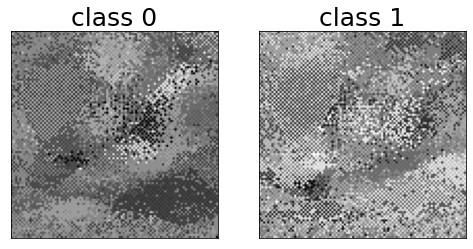

In [25]:
nrow = 2
ncol = 5
fig = plt.figure(figsize=(20, 50)) 
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.2, hspace=0.0, 
         top=0.5-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i, p in enumerate(res):
    _r= i // ncol
    _c= i % ncol
    ax= plt.subplot(gs[_r,_c])
    ax.imshow(p, cmap="gray")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title(f"class {i}", fontsize=25)

In [64]:
## count each feature selection
Counter(torch.argmax(actor.attention.log_alpha,dim=2).cpu().numpy()[0])

Counter({333: 151,
         377: 236,
         348: 146,
         129: 274,
         416: 59,
         323: 12,
         45: 142,
         475: 577,
         130: 105,
         241: 485,
         364: 91,
         215: 1,
         328: 8,
         76: 1,
         360: 3,
         10: 13,
         32: 68,
         422: 174,
         234: 9,
         47: 2,
         495: 44,
         113: 6,
         27: 6,
         238: 8,
         380: 11,
         260: 54,
         432: 48,
         29: 1,
         385: 4,
         308: 171,
         65: 259,
         320: 2,
         336: 37,
         97: 6,
         125: 2,
         171: 1,
         22: 62,
         426: 1,
         118: 1,
         186: 1,
         378: 10,
         451: 154,
         64: 27,
         334: 2,
         490: 1,
         66: 2,
         269: 13,
         375: 60,
         440: 44,
         99: 17,
         14: 47,
         74: 2,
         487: 1,
         363: 5,
         473: 3,
         208: 60,
         249: 33,
  

## Integrated Gradients

In [38]:
def get_important_pixels(attributions, thre=0.1):
    im = np.zeros((scale,scale))
    for idx1, i in enumerate(attributions[0][0]):
        for idx2, j in enumerate(i):
            if j > thre:
                im[idx1][idx2] = j
    p = []
    for idx1, i in enumerate(im):
        for idx2, j in enumerate(i):
            pos = idx1*(scale) + idx2
            if j != 0:
                p.append(pos)
    return im, p

def get_templates(n=-1):
    p = glob.glob(f'../template/alphabet/*')
    p.sort()
    templates = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in p]
    for i in range(len(templates)):
        templates[i] = templates[i]/255
    return templates

In [42]:
temp = get_templates()
temp = torch.tensor(temp).float()

In [43]:
critic.to(device)
critic.eval()
ig = IntegratedGradients(critic)

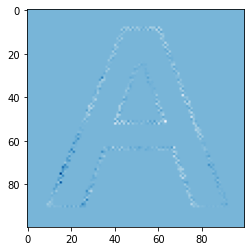

In [46]:
baseline = torch.zeros(1, 100, 100).unsqueeze(1).to(device)
class_idx = 0
attributions, delta = ig.attribute(temp[class_idx:class_idx+1].unsqueeze(0).to(device), baseline, target=class_idx, return_convergence_delta=True, )
plt.imshow(attributions.squeeze(1)[0].detach().cpu().numpy(),cmap=cmap0)

([], [])

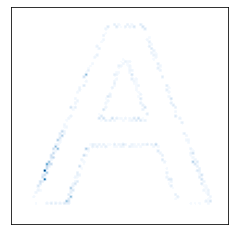

In [47]:
im,p = get_important_pixels(attributions.detach().cpu(), thre=0.001)
plt.imshow(im,cmap=cmap0)
plt.xticks([])
plt.yticks([])